<a href="https://colab.research.google.com/github/davidbau/rome/blob/gpt_stats/notebooks/statistics_of_GPT_states.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/davidbau/rome -b gpt_stats rome > install.log 2>&1
ln -s rome/counterfact .
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, sys
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")
    sys.path.append('/content/rome')
    IS_COLAB = True
except:
    pass

# Statistics of GPT states

Here we load GPT-2-XL and examine the statistics of its internal states.

We are particularly interested in: how close are the output values to Gaussian.

In [3]:
%load_ext autoreload
%autoreload 2

We build upon the ROME codebase.

There is an `experiments.causal_trace` module that contains some useful utility functions for loading large transformer models in colab.

In [4]:
import os, re, json, math
import torch, numpy
from collections import defaultdict
from experiments.causal_trace import ModelAndTokenizer, predict_token


Now we load GPT-2-XL and a tokenizer, and show that it can complete a couple factual statements correctly.

In [5]:
torch.set_grad_enabled(False)
mt = ModelAndTokenizer('gpt2-xl', low_cpu_mem_usage=IS_COLAB)
predict_token(mt, ['Shaquille O\'Neal plays the sport of',
               'Megan Rapinoe plays the sport of'
              ], return_p=True)

([' basketball', ' soccer'], tensor([0.5461, 0.7678], device='cuda:0'))

Now for some neutral text samples, we load some random texts from wikipedia.  Just a few (one batch for now).

In [8]:
from datasets import load_dataset
from baukit import TokenizedDataset, length_collation, flatten_masked_batch

def get_ds(ds_name='wikipedia', tokenizer=None, batch_tokens=None):
    raw_ds = load_dataset(
        ds_name,
        dict(wikitext="wikitext-103-raw-v1", wikipedia="20200501.en")[ds_name],
    )
    maxlen = mt.model.config.n_positions
    if batch_tokens is not None and batch_tokens < maxlen:
        maxlen = batch_tokens
    return TokenizedDataset(raw_ds["train"], tokenizer, maxlen=maxlen)
ds = get_ds(tokenizer=mt.tokenizer)

Reusing dataset wikipedia (/home/davidbau/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/009f923d9b6dd00c00c8cdc7f408f2b47f45dd4f5fb7982a21f9448f4afbe475)


  0%|          | 0/1 [00:00<?, ?it/s]

Grab an example batch of data

In [9]:
torch.set_grad_enabled(False)

batch_tokens = mt.model.config.n_positions * 3

loader = torch.utils.data.DataLoader(ds, batch_size=100, collate_fn=length_collation(batch_tokens), pin_memory=True)
for batch_group in loader:
    break


Let's create a tool that lets you see the predictions from a given prefix of the sentence.

You can use this to see that the GPT is operating correctly.

We will also use TraceDict to trace all the internal layers of the GPT network.


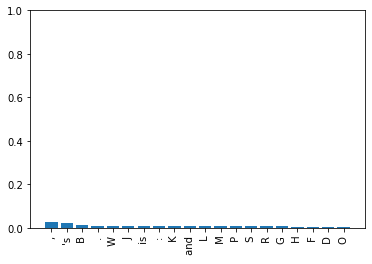
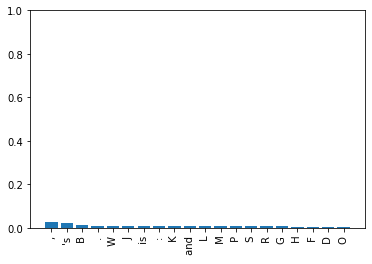

In [10]:
from baukit import Textarea, Range, show, PlotWidget, TraceDict, module_names
import re

trace_layer_names = [n for n in module_names(mt.model) if re.match(r'.*\.\d+(\.mlp|\.attn|)?$', n)]

# Grab the 12th batch in the batch-grouop
input = {k: v.cuda() for k, v in batch_group[12].items()}

with TraceDict(mt.model, trace_layer_names) as hidden_state:
    results = mt.model(**input)
all_hs = {k: v.output[0].cpu()
          if isinstance(v.output, tuple) else v.output.cpu()
          for k, v in hidden_state.items()
         }
layername = 'transformer.h.17'
hs = all_hs[layername]
logits = results['logits'][0].cpu()
tokens = input['input_ids'][0]


def redraw_text():
    tb.value = mt.tokenizer.decode(tokens[:ra.value+1])

    
def plot_predictions(fig, index=1, k=20):
    [ax] = fig.axes
    ax.clear()
    probs = torch.softmax(logits[index], dim=0)
    top_prob, top_tok = torch.topk(probs, dim=0, k=k)
    x = range(len(top_prob))
    labels = [mt.tokenizer.decode(t) for t in top_tok]
    ax.set_ylim(0,1)
    ax.bar(x, top_prob)
    ax.set_xticks(x, labels, rotation=90)


ra = Range(min=0, max=min(200, len(tokens)), value=0).on('value', redraw_text)
tb = Textarea()
plot = PlotWidget(plot_predictions, index=ra.prop('value'))
show([show.style(alignItems='flex-start'), [[ra, [show.style(width='500px', height='300px'), tb]], plot]])

Now, let's take a look at the distributions of hidden states.

Here is the UI code.  Basically we will:

  1. grab a sample of 2000 tokens from the batch
  2. examine the hidden state at a particular layer all those random tokens
  3. within this sample we plot the distribution of cosine similiarities between pairs

The layer to examine is selectable.

We can explore quantiles and examine the raw token pairs with a given similarity with a slider.


In [11]:
import numpy, random
from baukit import Menu

def show_gpt_state_distribution():
    attn_mask = input['attention_mask']
    input_ids = input['input_ids']
    
    def decode(i, t, prefix_len=10):
        if t+1 < input_ids.shape[1]:
            next_token = f'[{mt.tokenizer.decode(input_ids[i, t+1])}]'
        else:
            next_token = '<END>'
        return mt.tokenizer.decode(input_ids[i][max(0, t-prefix_len+1):t+1]) + next_token
        
    all_indexes = torch.tensor(numpy.array(numpy.unravel_index(range(input_ids.numel()), input_ids.shape)).T)
    flat_indexes = flatten_masked_batch(all_indexes, attn_mask)
    sample_size = 2000
    sample = random.sample(range(len(flat_indexes)), sample_size)
    inds = flat_indexes[sample]    

    
    num_pairs = (sample_size // 2) ** 2
    ra = Range(min=0, max=num_pairs - 1, value=num_pairs // 2)
    def drawme(plt, bins=200, to_show=num_pairs // 2, layername=layername):
        ax = plt.axes[0]
        ax.clear()
        ax.set_title(f'Cosine similarity between pairs of a random sample of {sample_size} wiki texts')
        
        flat = flatten_masked_batch(all_hs[layername], attn_mask)
        d = flat[sample]

        # Mean-center and normalize before computing angles.
        #d = d - d.mean(dim=1, keepdim=True)
        d = d / d.norm(dim=1, keepdim=True)
        angles = d[:len(d) // 2] @ d[len(d) // 2:].t()
        pairs = [(x, y) for x in range(len(d) // 2) for y in range(len(d) // 2, len(d))]
        sorted_angles, sorted_indexes = angles.view(-1).sort(dim=0)
        
        ax.hist(angles.view(-1).numpy(), bins=torch.linspace(-1, 1, bins), density=True)
        # ax.hist(angles.view(-1).numpy(), bins=bins, density=True)
        x, y = pairs[sorted_indexes[to_show]]
        [xi, xt], [yi, yt] = inds[x], inds[y]
        angle = angles[x, y - len(d) // 2]
        ax.axvline(angle, color='red')
        ta.value = f'''\
similarity {angle:.3g}: (sample {x}, sample {y})
--- sample {x}:
{decode(xi, xt)}
--- sample {y}:
{decode(yi, yt)}'''
    ch = Menu(choices=trace_layer_names, selection=layername)
    ta = Textarea()
    plot = PlotWidget(drawme, to_show=ra.prop('value'), figsize=(10,3), layername=ch.prop('selection'))
    show([[show.style(textAlign='right'), 'Layer:', ch],
          [show.style(textAlign='right'), 'Quantile:', ra],
          plot, show.attr(rows=10), ta])
# show_gpt_state_distribution()


To have a baseline to compare with, we do the same with an normal Gaussian distribution of the same dimensionality.

We note that if we actually reduce the dimensionality, we can get histograms that more resemble the true data distributions, so we provide a slider for adjusting the dimensionailty of the sample

In [12]:
import math
def show_gaussian_distribution():
    raw_data = torch.randn(2048, 1600)
    num_pairs = (len(raw_data) // 2) ** 2
    num_dimensions = raw_data.shape[1]
    
    def drawme(plt, bins=200, to_show=num_pairs // 2, dimensions=num_dimensions):
        ax = plt.axes[0]
        ax.clear()
        d = raw_data.clone()
        d[:,dimensions:] = 0
        d = d / d.norm(dim=1, keepdim=True)
        angles = d[:len(d) // 2] @ d[len(d) // 2:].t()
        pairs = [(x, y) for x in range(len(d) // 2) for y in range(len(d) - len(d) // 2)]
        sorted_angles, sorted_indexes = angles.view(-1).sort(dim=0)
        x, y = pairs[sorted_indexes[to_show]]
        angle = angles[x, y]
        
        ax.hist(angles.view(-1).numpy(), bins=torch.linspace(-1, 1, bins), density=True)
        ax.axvline(angle, color='red')
        ta.value = f'dimensions: {dimensions}\nsimilarity: {angle:.3g}: ({x}, {y + len(d) // 2})'
    rd = Range(min=0, max=num_dimensions, value=num_dimensions)
    ra = Range(min=0, max=num_pairs - 1, value=num_pairs // 2)
    ta = Textarea()
    plot = PlotWidget(drawme, to_show=ra.prop('value'), dimensions=rd.prop('value'), figsize=(10,3))
    show([[show.style(textAlign='right'), 'Dimensions:', rd],
          [show.style(textAlign='right'), 'Quantile:', ra],
          plot, show.attr(rows=2), ta])


Now we wish to ask: how close is the distribution of transformer hidden states to Gaussian?

We will take a sample of them, and see.


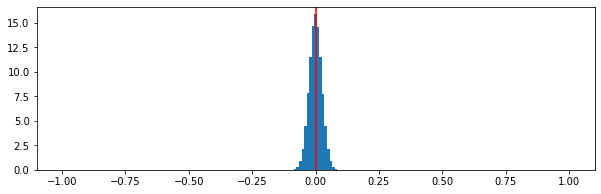
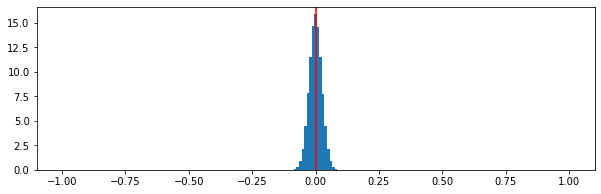


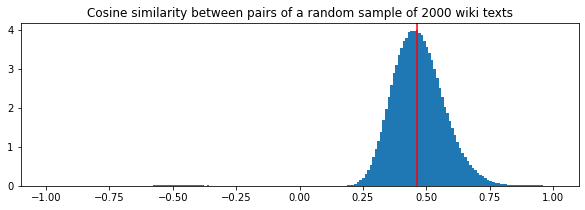
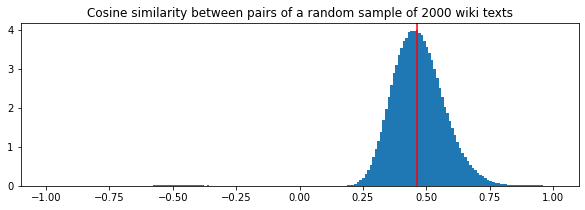

In [13]:
show_gaussian_distribution()
show_gpt_state_distribution()

Conclusions:

 * Hidden states and Attn output distributions are far from Gaussian.
 * But MLP outputs seem closer to Gaussian.
 * But they also behave as if they have lower dimension than the full dimensionality.
